# DNN model with sin/cos encoding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
import h5py 
import os 
import kerastuner as kt 
import IPython 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')
# , 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m'
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m']
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
DL1r_keys = list(filter(lambda a: 'DL1r' in a, dataset.keys()))


Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  500000

In [2]:
import scale_variables
import shape_timesteps

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'meanmax', 'eta':'meanmax', 'phi':'sincos', 'DL1r':'meanmax', 'm':'meanmax', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(Y_keys, Y_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 1.1368683772161603e-13


In [3]:
# Create X and test array
split = int(np.floor(0.9*crop0)) # 80/20 split 

trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

# Save some memory 
del totalX_jets
del totalX_other 

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(450000, 6, 6) (450000, 7) (450000, 10)
(50000, 6, 6) (50000, 7) (50000, 10)


In [4]:
# Histograms of total  Y variables 
show = False

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-0.1, 0.1, 40)
pt_bins = np.linspace(-0.3, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [5]:
# Histograms of X variables (without the mask)
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

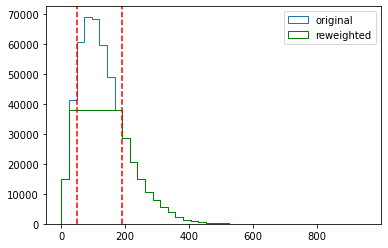

In [6]:
th_pt = np.array(dataset.get('th_pt'))[0:crop0]
hist1, bins = np.histogram(th_pt, 40)
hist1 = hist1 + (hist1<=0)*1
bins[-1] = np.inf
plt.hist(th_pt, 40, histtype='step', label='original')
argright = 8
argleft = 2
right = bins[argright]
left = bins[argleft]
compare_min = hist1[argright-1]
plt.axvline(x=left, color='r', linestyle='--')
plt.axvline(x=right, color='r', linestyle='--')
flat = 1
belong = np.digitize(th_pt, bins) - 1
factor = compare_min/hist1*(hist1>=compare_min) + (hist1<compare_min)
weight = factor[belong]
plt.hist(th_pt, bins, histtype='step', label='reweighted', color='g', weights=weight)
plt.legend()

In [7]:
# Build model

def build_model(hp):
    initializer = initializers.he_normal()
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    other_input = Input(shape=(trainX_other.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    L1 = Dense(hp.Int('input_units', min_value=128, max_value=512, step=32), activation='relu',kernel_initializer=initializer)(concat0)
    for i in range(hp.Int('n_layersDense', 1,6)):
        L1 = Dense(hp.Int('input_units', min_value=32, max_value=320, step=32), activation='relu',kernel_initializer=initializer)(L1)
    output = Dense(len(Y_names), activation='linear')(L1)
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[5e-5, 2.5e-5, 1e-5,5e-6,1e-6]))
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model 

tuner = kt.Hyperband(build_model,
                     objective = 'val_mse', 
                     max_epochs = 10,
                     factor = 3,
                     directory = './tuners',
                     project_name = 'dnn-parasearch_sincos')  

In [8]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

tuner.search([trainX_jets, trainX_other], trainY, epochs = 10, validation_data = ([testX_jets, testX_other], testY), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)

INFO:tensorflow:Oracle triggered exit


In [9]:
model = tuner.hypermodel.build(best_hps)

K.set_value(model.optimizer.learning_rate, 0.5e-5)
print("Learning rate: {}".format(K.eval(model.optimizer.lr)))
model.summary()




Learning rate: 4.999999873689376e-06
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 6)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 36)           0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 43)           0           input_2[0][0]                    
                                                         

In [10]:
# Build the model with the optimal hyperparameters and train it on the data



callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
Epochs= 512
history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs, 
                   validation_data=([testX_jets, testX_other], testY), shuffle=False, callbacks=[callback],
                   batch_size=512)

Train on 450000 samples, validate on 50000 samples
Epoch 1/512
450000/450000 [==============================] - ETA: 6:15 - loss: 0.1129 - mse: 0.112 - ETA: 27s - loss: 0.1043 - mse: 0.104 - ETA: 16s - loss: 0.0970 - mse: 0.09 - ETA: 11s - loss: 0.0909 - mse: 0.09 - ETA: 9s - loss: 0.0856 - mse: 0.0856 - ETA: 8s - loss: 0.0807 - mse: 0.080 - ETA: 7s - loss: 0.0765 - mse: 0.076 - ETA: 7s - loss: 0.0726 - mse: 0.072 - ETA: 6s - loss: 0.0696 - mse: 0.069 - ETA: 6s - loss: 0.0666 - mse: 0.066 - ETA: 5s - loss: 0.0639 - mse: 0.063 - ETA: 5s - loss: 0.0614 - mse: 0.061 - ETA: 5s - loss: 0.0592 - mse: 0.059 - ETA: 4s - loss: 0.0571 - mse: 0.057 - ETA: 4s - loss: 0.0554 - mse: 0.055 - ETA: 4s - loss: 0.0537 - mse: 0.053 - ETA: 4s - loss: 0.0521 - mse: 0.052 - ETA: 4s - loss: 0.0508 - mse: 0.050 - ETA: 4s - loss: 0.0494 - mse: 0.049 - ETA: 3s - loss: 0.0482 - mse: 0.048 - ETA: 3s - loss: 0.0471 - mse: 0.047 - ETA: 3s - loss: 0.0460 - mse: 0.046 - ETA: 3s - loss: 0.0450 - mse: 0.045 - ETA: 3s - 

450000/450000 [==============================] - ETA: 4s - loss: 0.0090 - mse: 0.009 - ETA: 3s - loss: 0.0094 - mse: 0.009 - ETA: 3s - loss: 0.0093 - mse: 0.009 - ETA: 3s - loss: 0.0093 - mse: 0.009 - ETA: 3s - loss: 0.0093 - mse: 0.009 - ETA: 3s - loss: 0.0092 - mse: 0.009 - ETA: 3s - loss: 0.0092 - mse: 0.009 - ETA: 3s - loss: 0.0092 - mse: 0.009 - ETA: 3s - loss: 0.0092 - mse: 0.009 - ETA: 3s - loss: 0.0092 - mse: 0.009 - ETA: 3s - loss: 0.0092 - mse: 0.009 - ETA: 3s - loss: 0.0092 - mse: 0.009 - ETA: 3s - loss: 0.0091 - mse: 0.009 - ETA: 3s - loss: 0.0091 - mse: 0.009 - ETA: 3s - loss: 0.0091 - mse: 0.009 - ETA: 3s - loss: 0.0091 - mse: 0.009 - ETA: 2s - loss: 0.0091 - mse: 0.009 - ETA: 2s - loss: 0.0091 - mse: 0.009 - ETA: 2s - loss: 0.0091 - mse: 0.009 - ETA: 2s - loss: 0.0091 - mse: 0.009 - ETA: 2s - loss: 0.0090 - mse: 0.009 - ETA: 2s - loss: 0.0090 - mse: 0.009 - ETA: 2s - loss: 0.0090 - mse: 0.009 - ETA: 2s - loss: 0.0090 - mse: 0.009 - ETA: 2s - loss: 0.0090 - mse: 0.009 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 3s - loss: 0.0069 - mse: 0.006 - ETA: 3s - loss: 0.0068 - mse: 0.006 - ETA: 3s - loss: 0.0068 - mse: 0.006 - ETA: 3s - loss: 0.0068 - mse: 0.006 - ETA: 3s - loss: 0.0068 - mse: 0.006 - ETA: 3s - loss: 0.0068 - mse: 0.006 - ETA: 3s - loss: 0.0068 - mse: 0.006 - ETA: 3s - loss: 0.0068 - mse: 0.006 - ETA: 3s - loss: 0.0068 - mse: 0.006 - ETA: 3s - loss: 0.0068 - mse: 0.006 - ETA: 3s - loss: 0.0068 - mse: 0.006 - ETA: 3s - loss: 0.0068 - mse: 0.006 - ETA: 3s - loss: 0.0068 - mse: 0.006 - ETA: 3s - loss: 0.0068 - mse: 0.006 - ETA: 3s - loss: 0.0068 - mse: 0.006 - ETA: 2s - loss: 0.0068 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 3s - loss: 0.0058 - mse: 0.005 - ETA: 3s - loss: 0.0058 - mse: 0.005 - ETA: 3s - loss: 0.0058 - mse: 0.005 - ETA: 3s - loss: 0.0058 - mse: 0.005 - ETA: 3s - loss: 0.0058 - mse: 0.005 - ETA: 3s - loss: 0.0058 - mse: 0.005 - ETA: 3s - loss: 0.0058 - mse: 0.005 - ETA: 3s - loss: 0.0058 - mse: 0.005 - ETA: 3s - loss: 0.0058 - mse: 0.005 - ETA: 3s - loss: 0.0058 - mse: 0.005 - ETA: 3s - loss: 0.0058 - mse: 0.005 - ETA: 3s - loss: 0.0058 - mse: 0.005 - ETA: 3s - loss: 0.0058 - mse: 0.005 - ETA: 3s - loss: 0.0058 - mse: 0.005 - ETA: 2s - loss: 0.0058 - mse: 0.005 - ETA: 2s - loss: 0.0058 - mse: 0.005 - ETA: 2s - loss: 0.0058 - mse: 0.005 - ETA: 2s - loss: 0.0057 - mse: 0.005 - ETA: 2s - loss: 0.0057 - mse: 0.005 - ETA: 2s - loss: 0.0057 - mse: 0.005 - ETA: 2s - loss: 0.0058 - mse: 0.005 - ETA: 2s - loss: 0.0057 - mse: 0.005 - ETA: 2s - loss: 0.0057 - mse: 0.005 - ETA: 2s - loss: 0.0057 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 3s - loss: 0.0052 - mse: 0.005 - ETA: 3s - loss: 0.0052 - mse: 0.005 - ETA: 3s - loss: 0.0052 - mse: 0.005 - ETA: 3s - loss: 0.0053 - mse: 0.005 - ETA: 3s - loss: 0.0052 - mse: 0.005 - ETA: 3s - loss: 0.0052 - mse: 0.005 - ETA: 3s - loss: 0.0052 - mse: 0.005 - ETA: 3s - loss: 0.0052 - mse: 0.005 - ETA: 3s - loss: 0.0052 - mse: 0.005 - ETA: 3s - loss: 0.0052 - mse: 0.005 - ETA: 3s - loss: 0.0052 - mse: 0.005 - ETA: 3s - loss: 0.0052 - mse: 0.005 - ETA: 3s - loss: 0.0052 - mse: 0.005 - ETA: 3s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 3s - loss: 0.0049 - mse: 0.004 - ETA: 3s - loss: 0.0049 - mse: 0.004 - ETA: 3s - loss: 0.0049 - mse: 0.004 - ETA: 3s - loss: 0.0049 - mse: 0.004 - ETA: 3s - loss: 0.0049 - mse: 0.004 - ETA: 3s - loss: 0.0049 - mse: 0.004 - ETA: 3s - loss: 0.0049 - mse: 0.004 - ETA: 3s - loss: 0.0049 - mse: 0.004 - ETA: 3s - loss: 0.0049 - mse: 0.004 - ETA: 3s - loss: 0.0049 - mse: 0.004 - ETA: 3s - loss: 0.0049 - mse: 0.004 - ETA: 3s - loss: 0.0049 - mse: 0.004 - ETA: 3s - loss: 0.0049 - mse: 0.004 - ETA: 3s - loss: 0.0049 - mse: 0.004 - ETA: 3s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0046 - mse: 0.004 - ETA: 3s - loss: 0.0047 - mse: 0.004 - ETA: 3s - loss: 0.0047 - mse: 0.004 - ETA: 3s - loss: 0.0047 - mse: 0.004 - ETA: 3s - loss: 0.0047 - mse: 0.004 - ETA: 3s - loss: 0.0047 - mse: 0.004 - ETA: 3s - loss: 0.0047 - mse: 0.004 - ETA: 3s - loss: 0.0047 - mse: 0.004 - ETA: 3s - loss: 0.0047 - mse: 0.004 - ETA: 3s - loss: 0.0047 - mse: 0.004 - ETA: 3s - loss: 0.0047 - mse: 0.004 - ETA: 3s - loss: 0.0047 - mse: 0.004 - ETA: 3s - loss: 0.0047 - mse: 0.004 - ETA: 3s - loss: 0.0047 - mse: 0.004 - ETA: 3s - loss: 0.0047 - mse: 0.004 - ETA: 3s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0045 - mse: 0.004 - ETA: 3s - loss: 0.0045 - mse: 0.004 - ETA: 3s - loss: 0.0045 - mse: 0.004 - ETA: 3s - loss: 0.0045 - mse: 0.004 - ETA: 3s - loss: 0.0045 - mse: 0.004 - ETA: 3s - loss: 0.0045 - mse: 0.004 - ETA: 3s - loss: 0.0045 - mse: 0.004 - ETA: 3s - loss: 0.0045 - mse: 0.004 - ETA: 3s - loss: 0.0045 - mse: 0.004 - ETA: 3s - loss: 0.0045 - mse: 0.004 - ETA: 3s - loss: 0.0045 - mse: 0.004 - ETA: 3s - loss: 0.0045 - mse: 0.004 - ETA: 3s - loss: 0.0045 - mse: 0.004 - ETA: 3s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 3s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0043 - mse: 0.004 - ETA: 3s - loss: 0.0043 - mse: 0.004 - ETA: 3s - loss: 0.0043 - mse: 0.004 - ETA: 3s - loss: 0.0043 - mse: 0.004 - ETA: 3s - loss: 0.0043 - mse: 0.004 - ETA: 3s - loss: 0.0043 - mse: 0.004 - ETA: 3s - loss: 0.0043 - mse: 0.004 - ETA: 3s - loss: 0.0043 - mse: 0.004 - ETA: 3s - loss: 0.0043 - mse: 0.004 - ETA: 3s - loss: 0.0043 - mse: 0.004 - ETA: 3s - loss: 0.0043 - mse: 0.004 - ETA: 3s - loss: 0.0043 - mse: 0.004 - ETA: 3s - loss: 0.0043 - mse: 0.004 - ETA: 3s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 3s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0041 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0040 - mse: 0.004 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0040 - mse: 0.004 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0039 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0039 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0035 - mse: 0.003 - ETA: 4s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0038 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0038 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0037 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0033 - mse: 0.003 - ETA: 4s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0037 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0036 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0036 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0035 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 4s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 4s - loss: 0.0033 - mse: 0.003 - ETA: 4s - loss: 0.0034 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0031 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 4s - loss: 0.0033 - mse: 0.003 - ETA: 4s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0033 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 5s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

450000/450000 [==============================] - ETA: 4s - loss: 0.0030 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 3s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - ETA: 2s - loss: 0.0032 - mse: 0.003 - E

Text(0.5, 1.0, 'MSE loss')

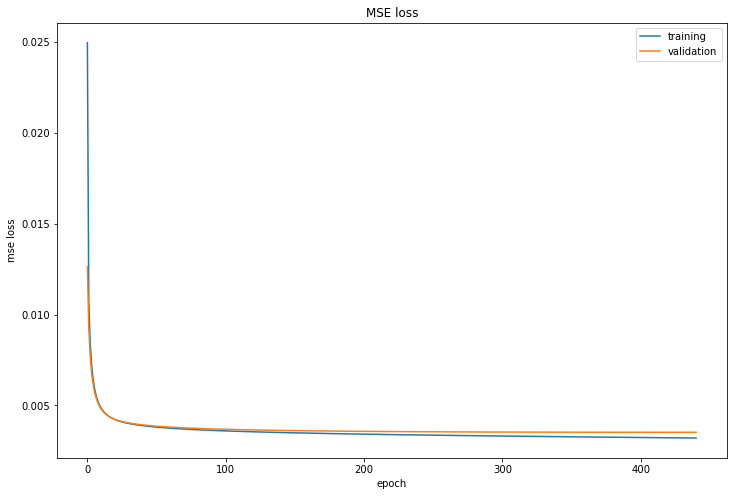

In [11]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [12]:
predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

In [13]:
# np.save('true', predictions_origscale)
# np.save('pred', true_origscale)

# Training scale plots 

In [14]:
import analysis

Analysis = analysis.Analysis 
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.003513274099180097
 
th_pt MSE :  0.0026515336
th_eta MSE :  0.0094340198
th_phi-sin MSE :  0.0016871023
th_phi-cos MSE :  0.0014483092
th_m MSE :  0.0039345663
tl_pt MSE :  0.0023160391
tl_eta MSE :  0.0067114706
tl_phi-sin MSE :  0.0012665826
tl_phi-cos MSE :  0.0010024622
tl_m MSE :  0.0046806552


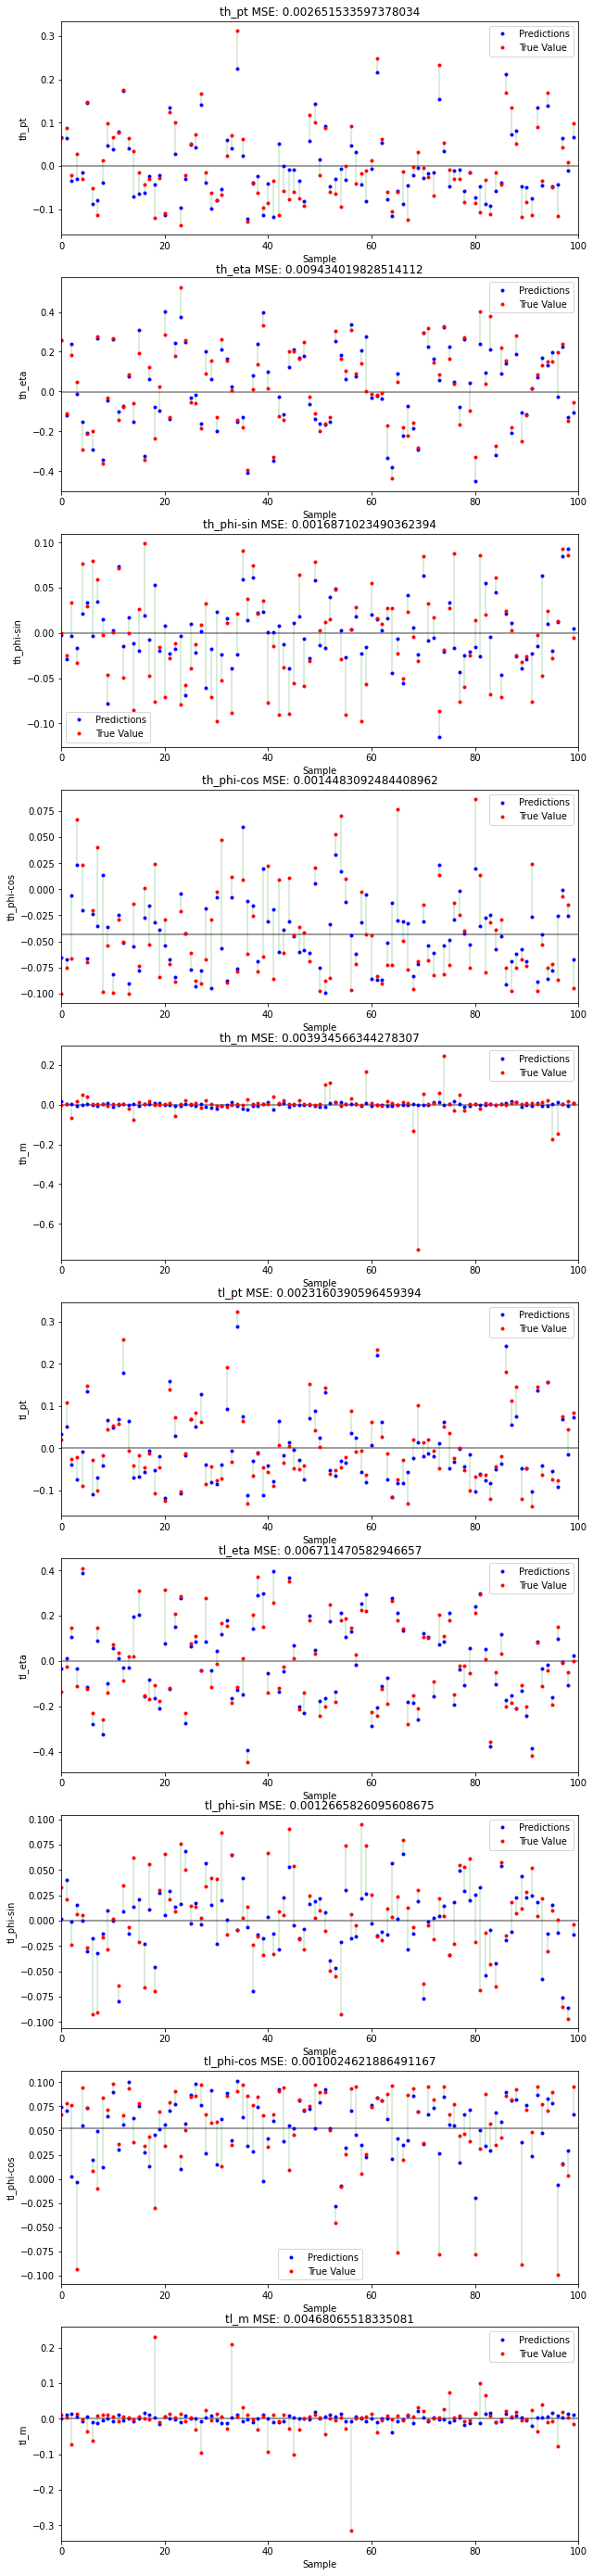

In [15]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

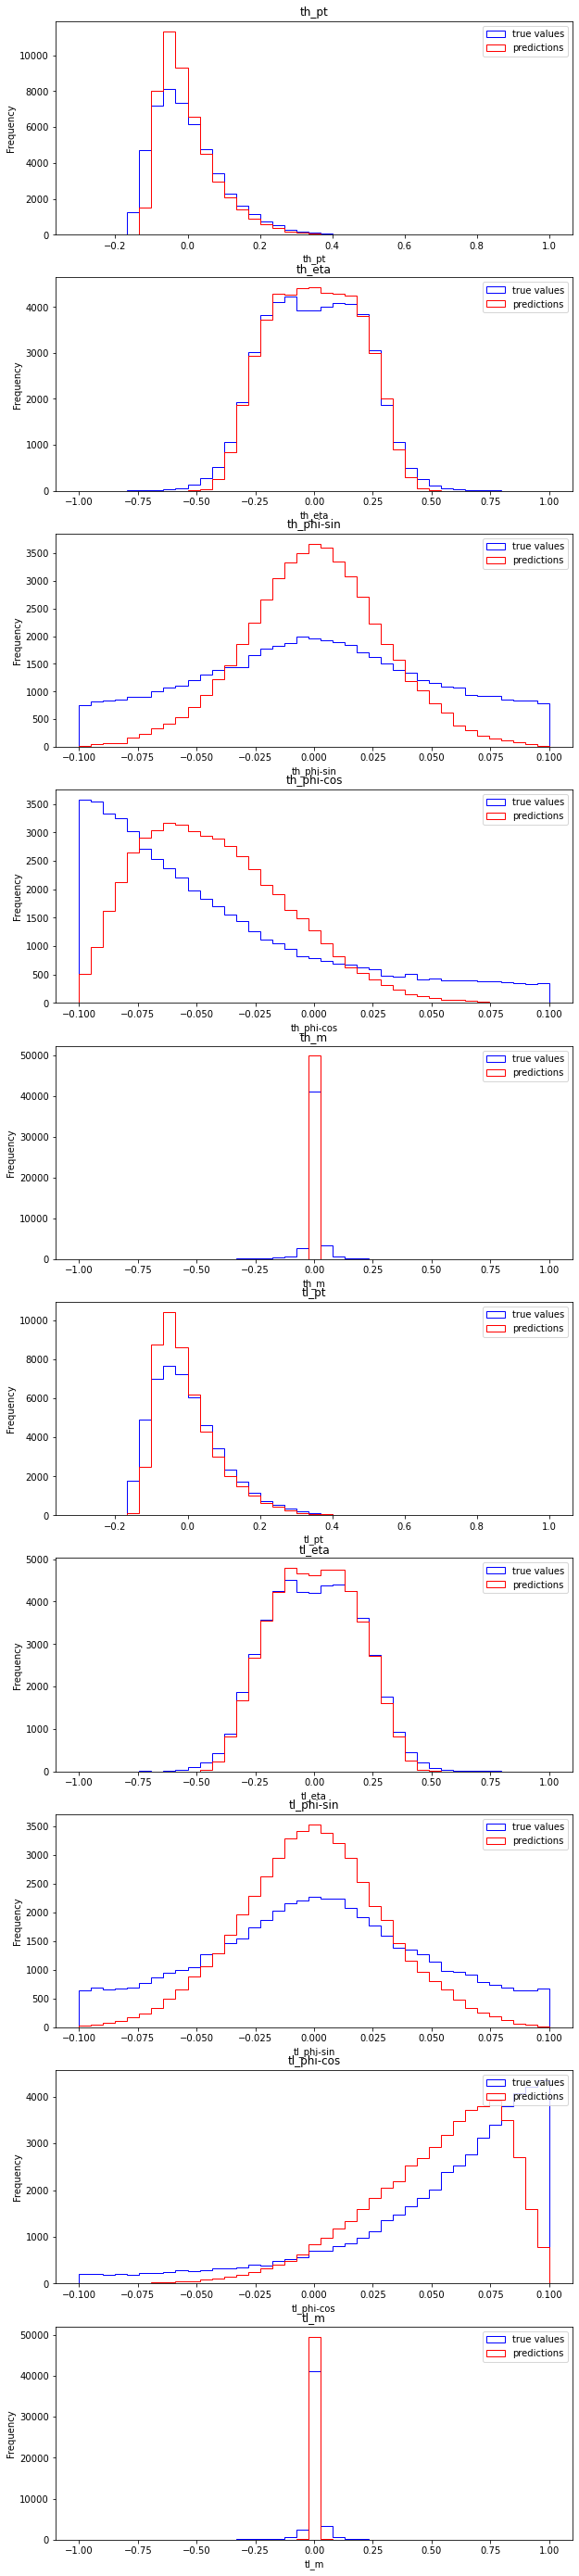

In [16]:
Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

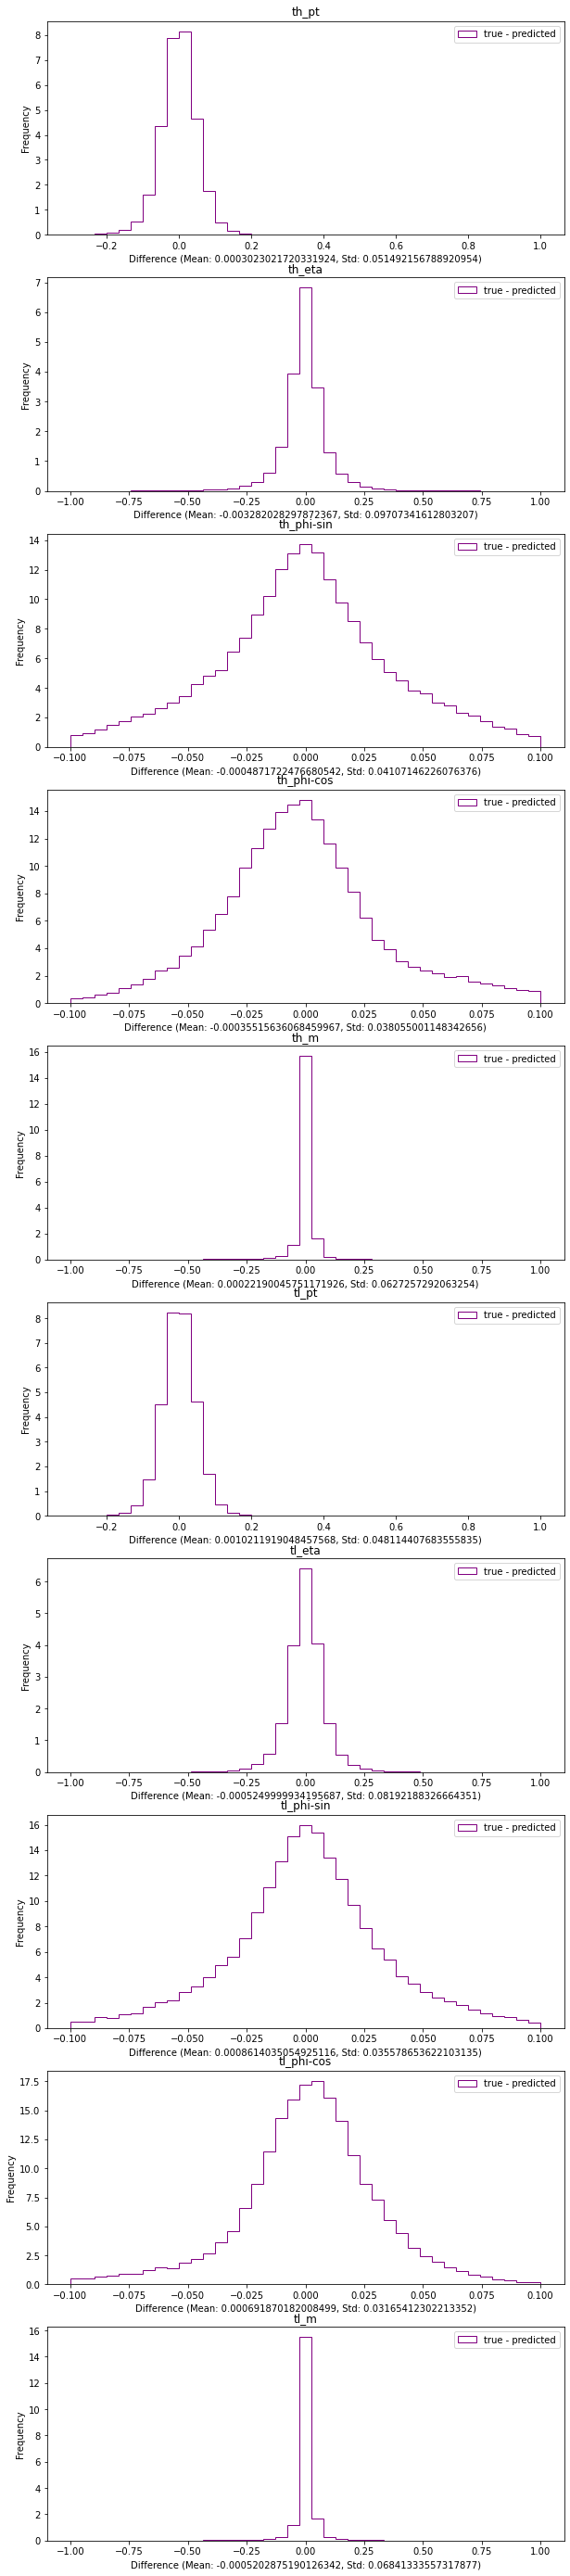

In [17]:
Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

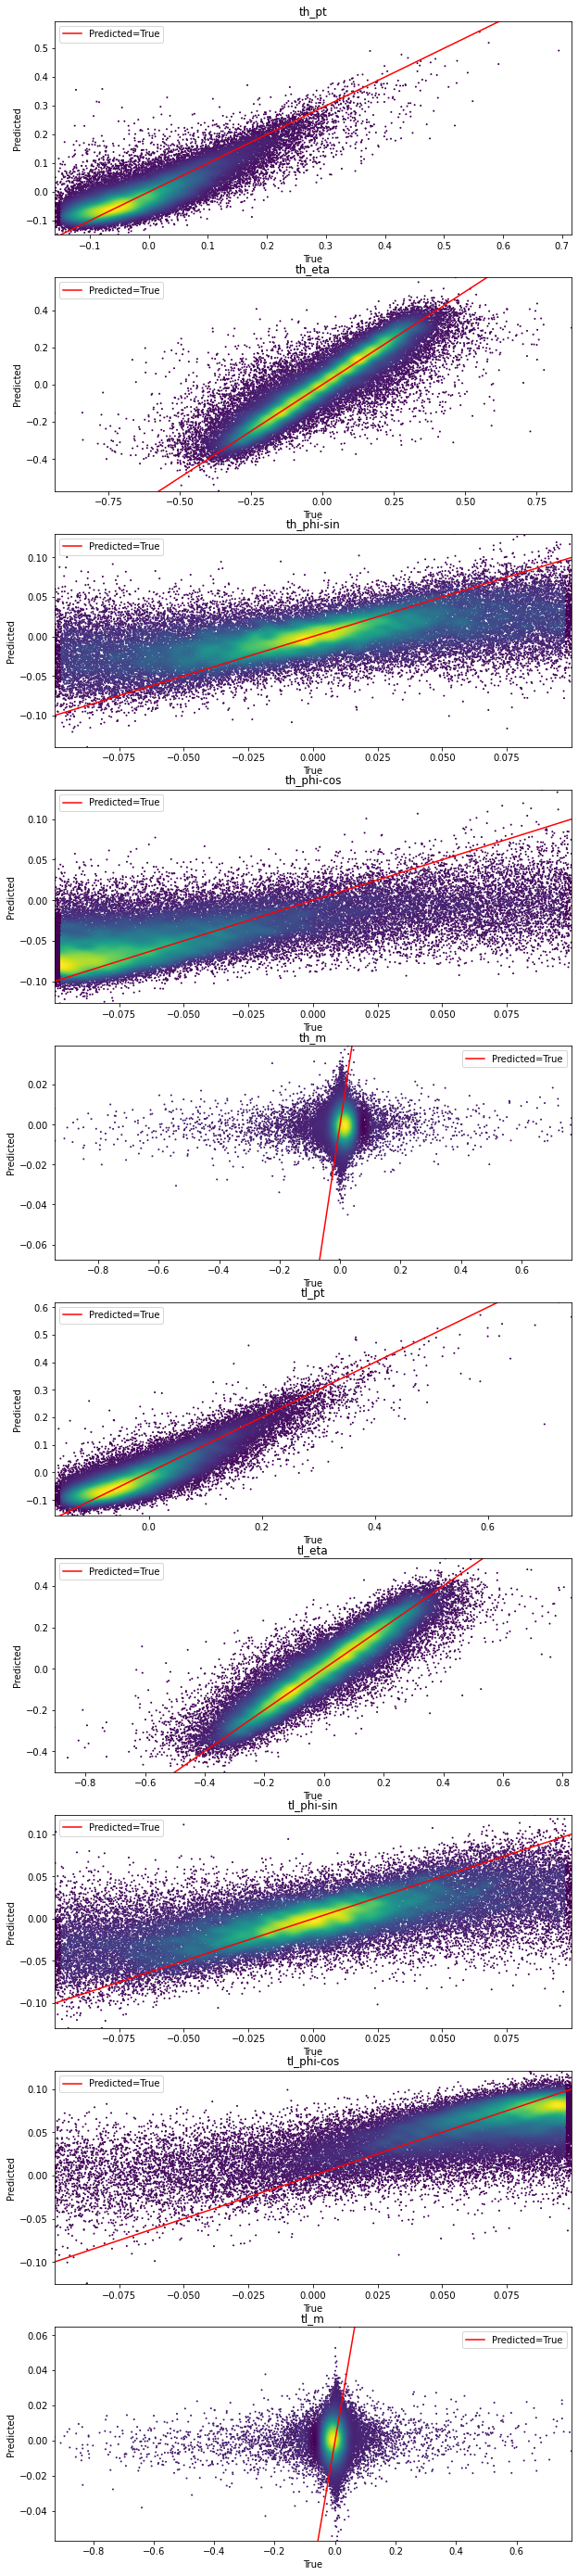

In [18]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [19]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 413.44223383692616
 
th_pt MSE :  1785.3367877626
th_eta MSE :  0.5595609252
th_phi MSE :  0.8956971006
th_m MSE :  33.0118539311
tl_pt MSE :  1443.2114908137
tl_eta MSE :  0.4235534535
tl_phi MSE :  0.5693708423
tl_m MSE :  39.3597804213


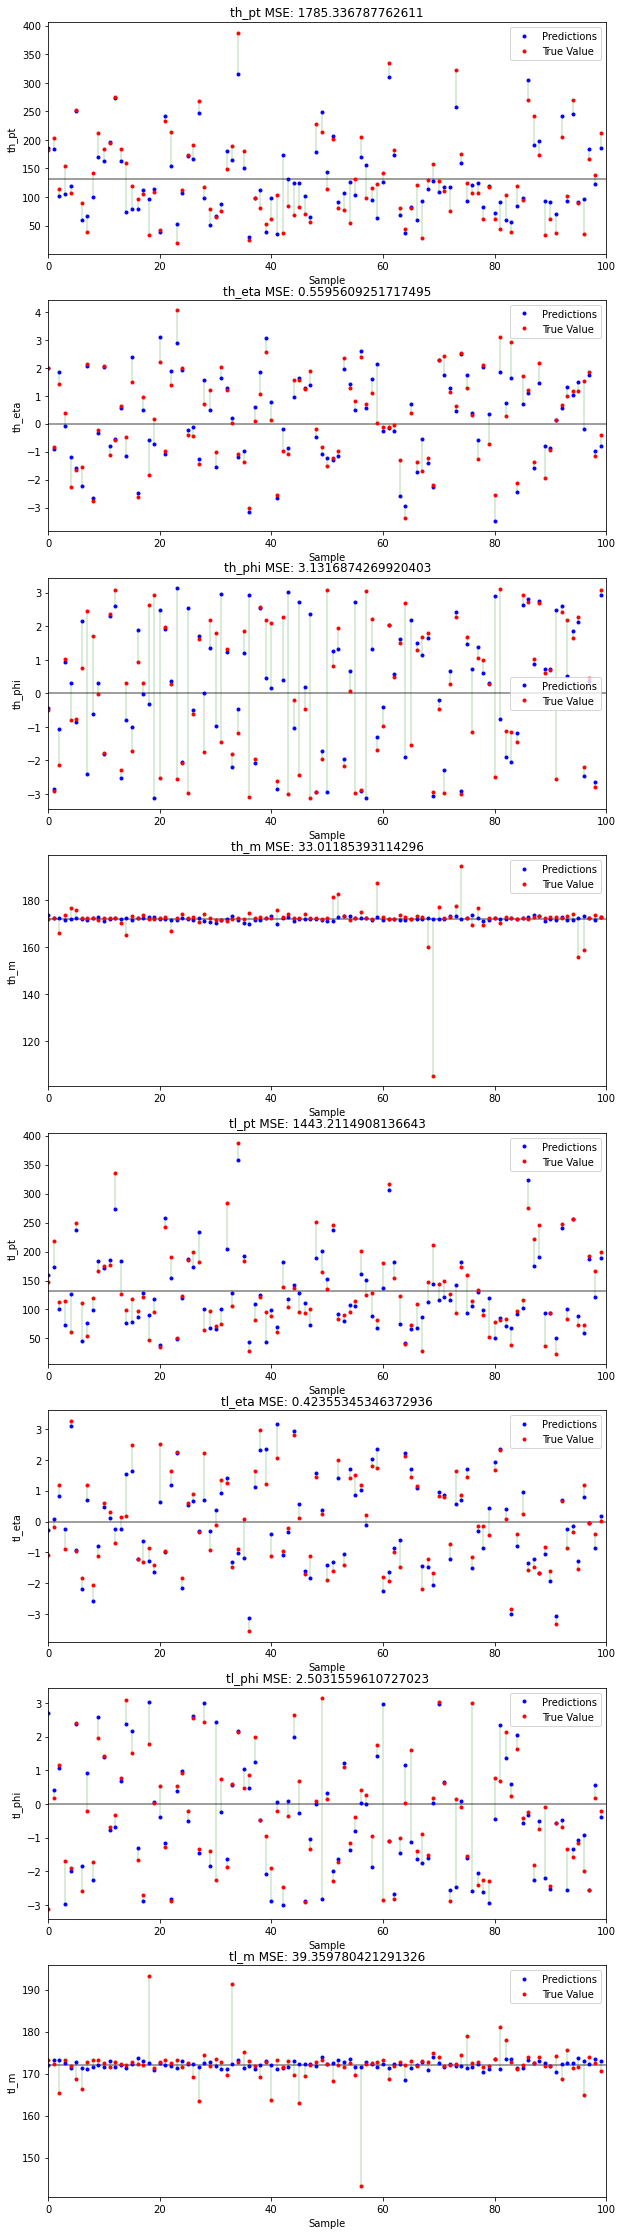

In [20]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

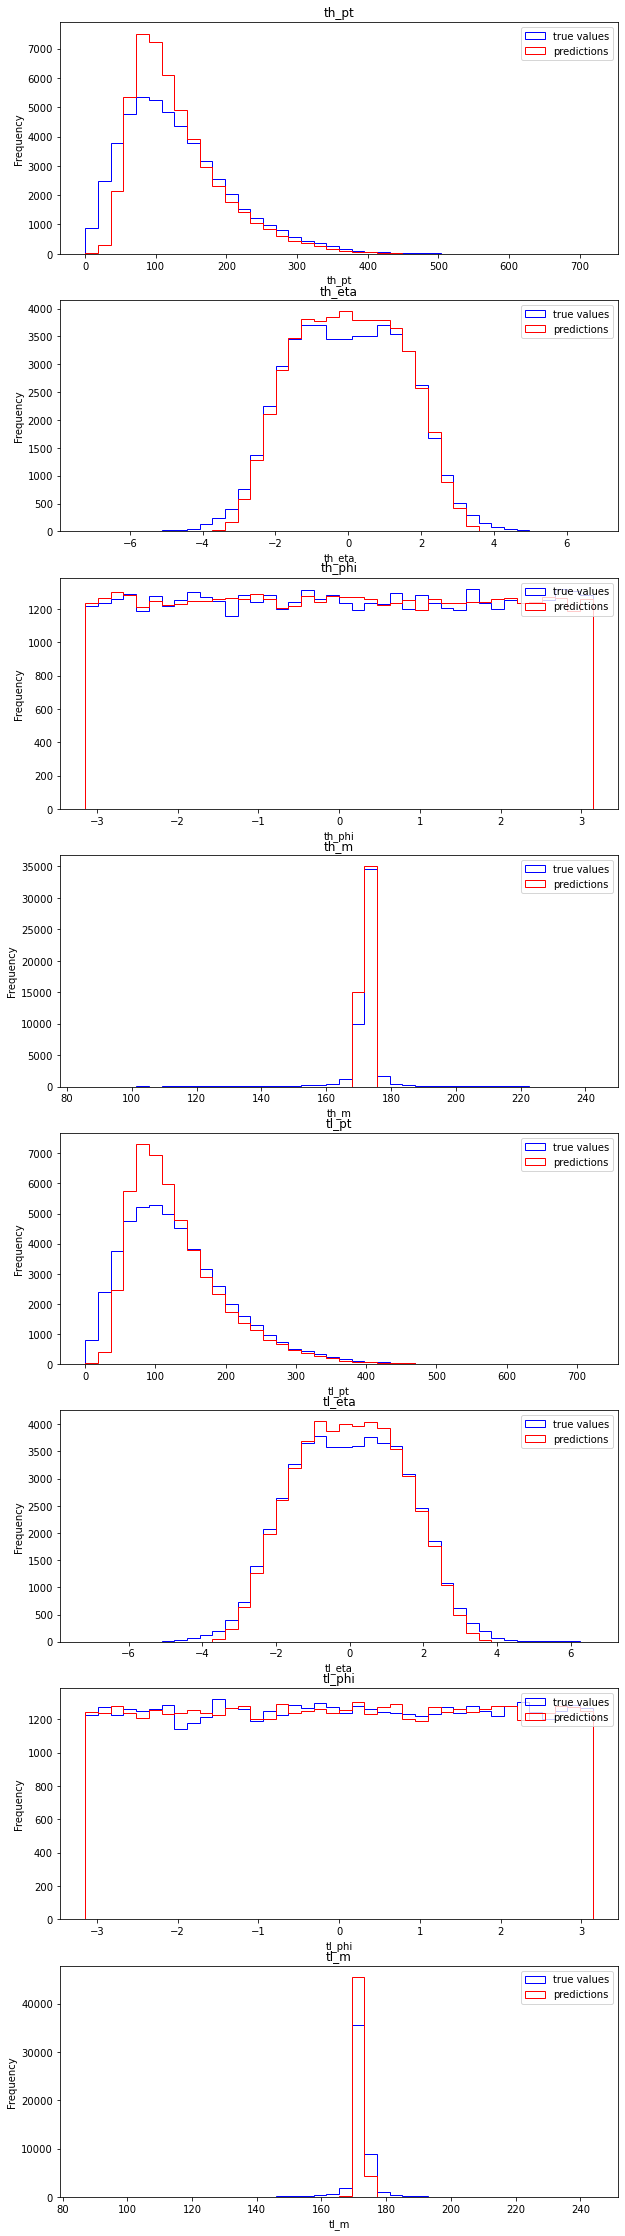

In [21]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

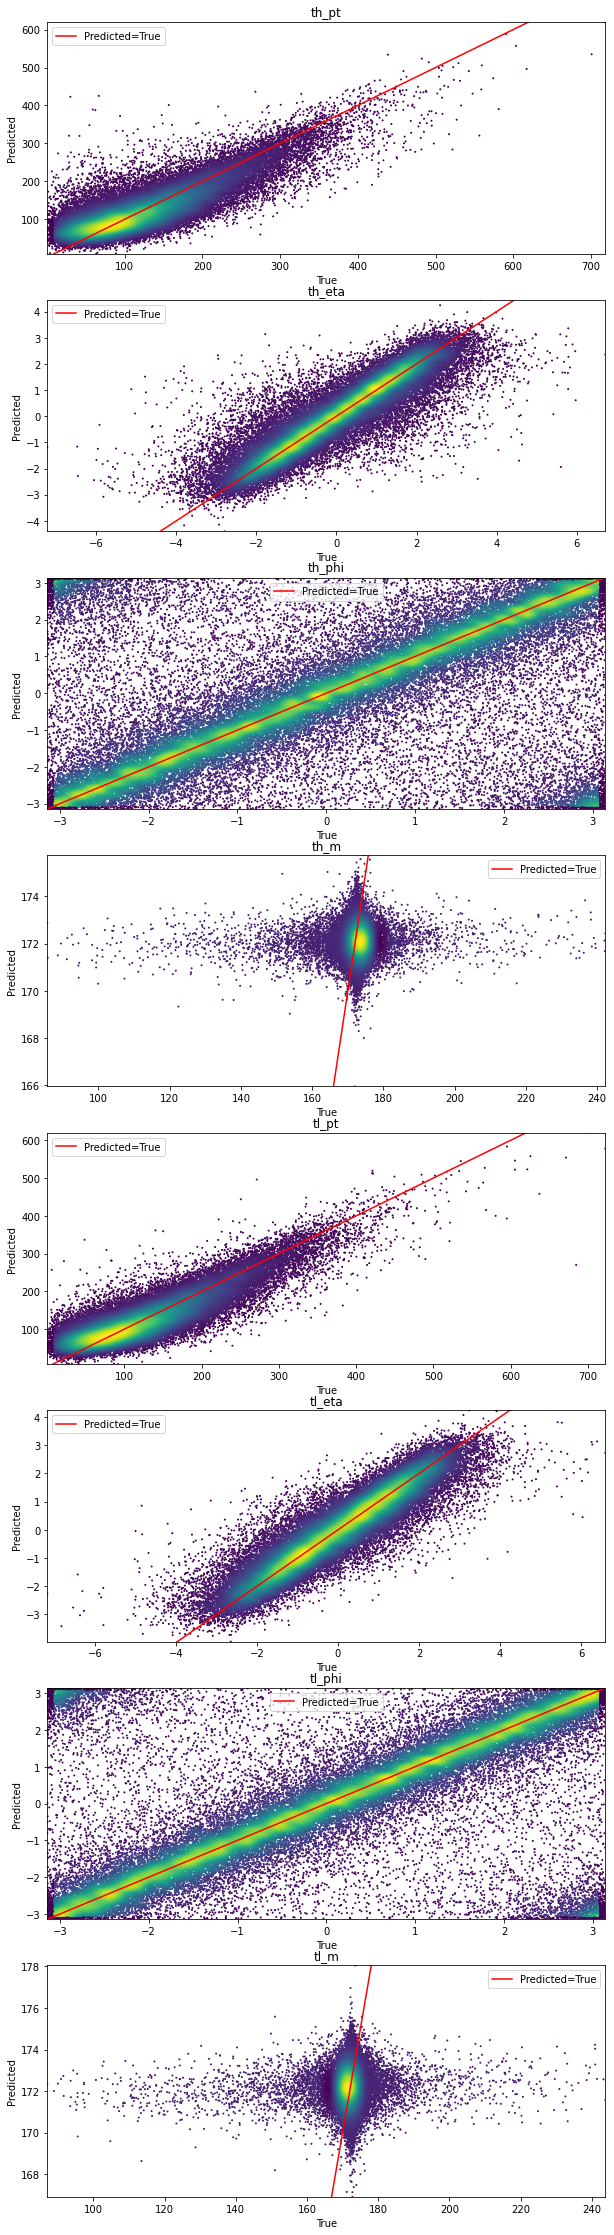

In [22]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

# Observables

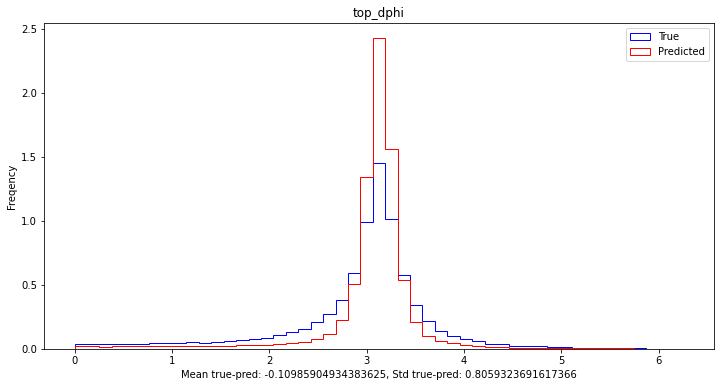

In [23]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

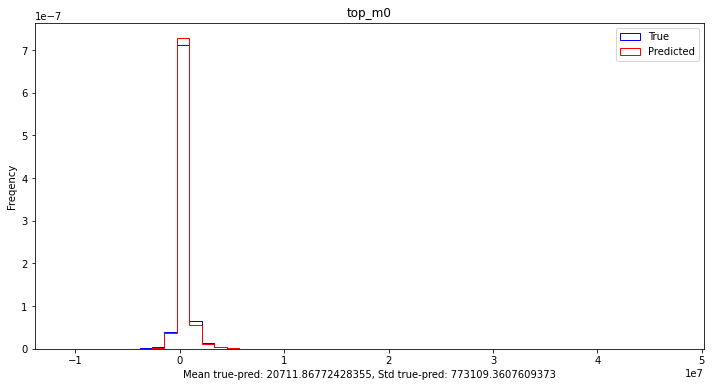

In [24]:
# top_m0= th_m**2-th_p**2 + tl_m**2-tl_p**2
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_m0'],preds['top_m0'])

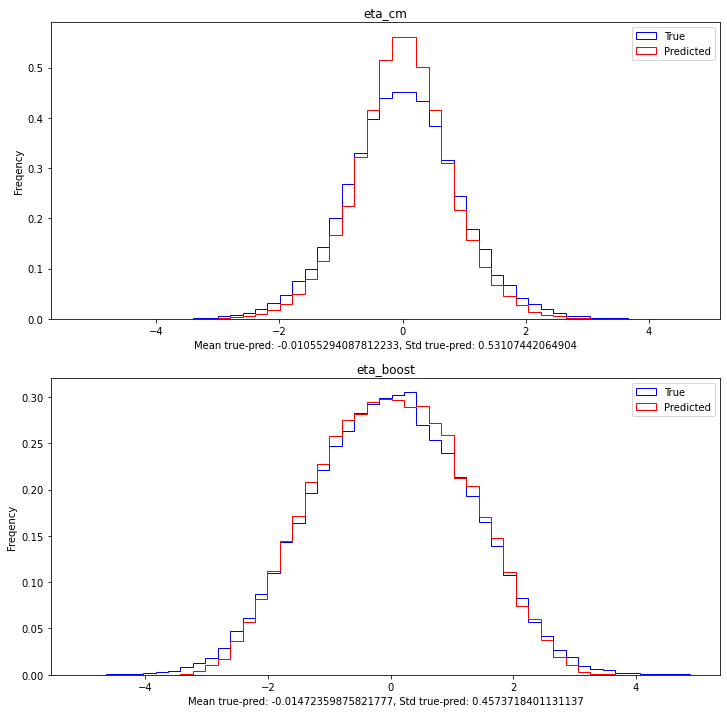

In [25]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])


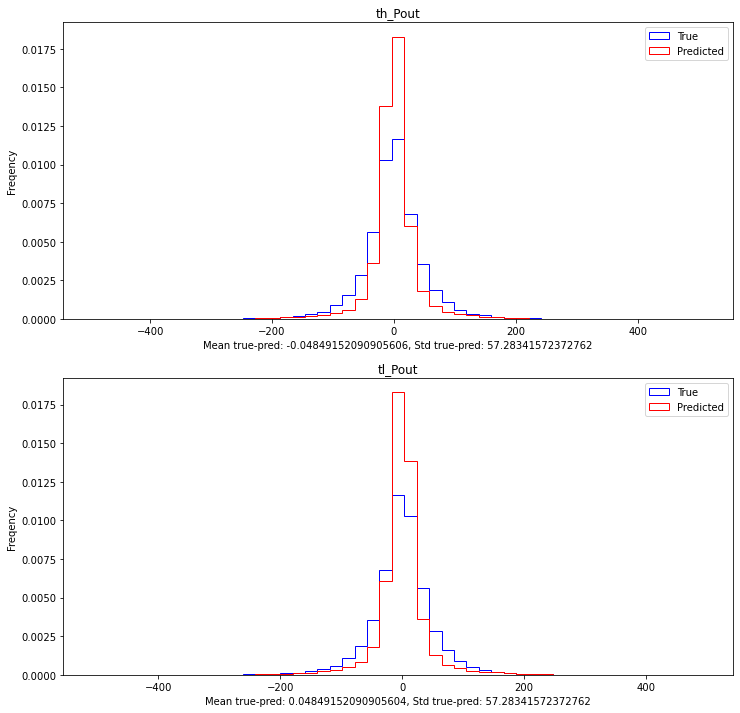

In [26]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])

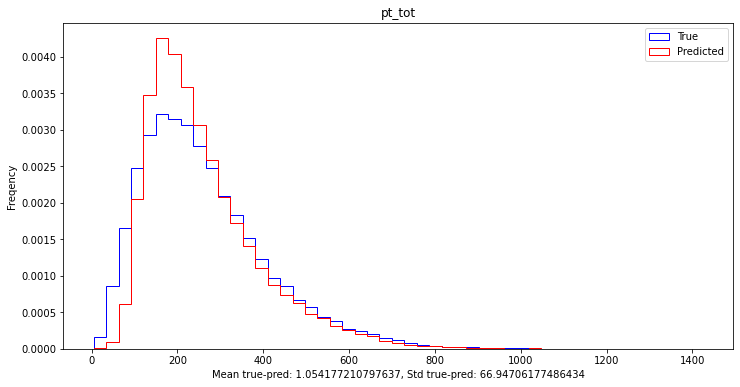

In [27]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])

In [28]:
model.save('dnn-parasearch_sincos.keras')